## Preparation

### Libraries

In [1]:
try:
    import secmlt
    
except ImportError:
    %pip install git+https://github.com/pralab/secml-torch

from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from secmlt.metrics.classification import Accuracy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import torch

from secmlt.trackers.trackers import Tracker
from secmlt.trackers.trackers import MULTI_SCALAR

from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

### Points generation

We create some data using another library called `scikit-learn`.

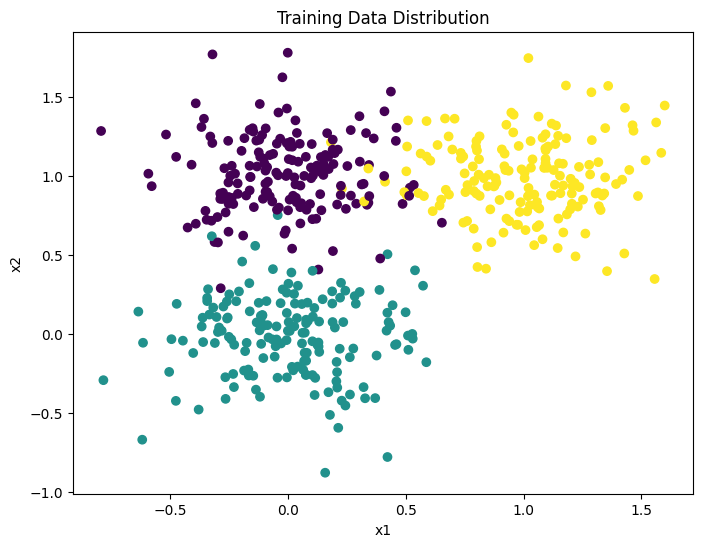

Data shape: torch.Size([500, 2])
Labels shape: torch.Size([500])


In [2]:
def plot_data(X, y, title="Data Distribution"):
    """
    Plot the data points colored by their classes.
    
    Args:
        X: Input features as tensor or numpy array
        y: Labels as tensor or numpy array
        title: Plot title
    """
    # Convert tensors to numpy if needed
    if torch.is_tensor(X):
        X = X.detach().numpy()
    if torch.is_tensor(y):
        y = y.detach().numpy()
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

centers = [(0, 1), (0, 0), (1, 1)]
cluster_std = 0.25

X_train, y_train = make_blobs(n_samples=500, 
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=999)

# Visualize the data
plot_data(X_train, y_train, title="Training Data Distribution")

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

print(f"Data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")

We do the same to create test data, that will be used to compute the accuracy of our model.

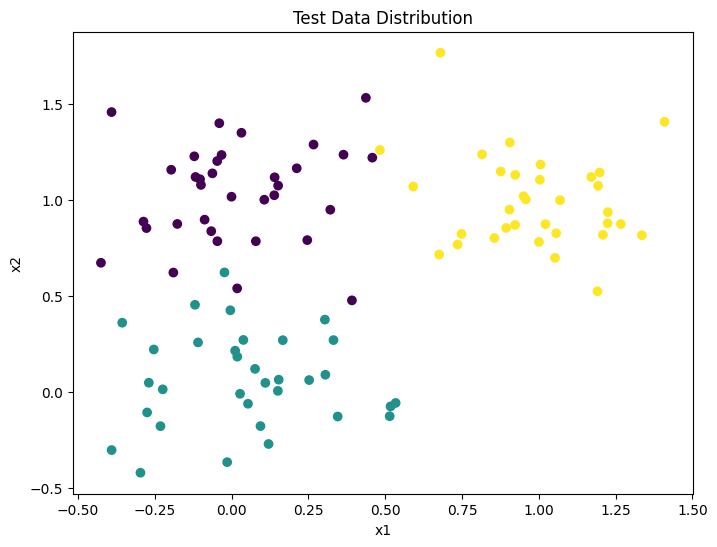

Data shape: torch.Size([100, 2])
Labels shape: torch.Size([100])


In [3]:
X_test, y_test = make_blobs(n_samples=100, 
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=999)

plot_data(X_test, y_test, title="Test Data Distribution")

# Convert to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"Data shape: {X_test.shape}")
print(f"Labels shape: {y_test.shape}")

We also already converted those samples in torch Tensors, which are the basic and main Pytorch objects.
Observations are defined as FloatTensors, while labels are LongTensors.

We can now create a main concept in Pytorch, which is the DataLoader.
A DataLoader dispatches data in batches, ready to be used to train models.

In [4]:
tr_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
ts_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=5, shuffle=False)

print(f"Number of batches: {len(tr_dataloader)}")

Number of batches: 16


### Neural Networks

We create two similar neural networks, which will be used as comparison in terms of accuracy and robustness.<br>
To train them, we need:

* a Loss Function, which quantifies the errors of the model
* an Optimization Algorithm, to fine-tune the parameters of the model

Hence, through gradient-descent it's possible to iteratively find the optimal parameters.

Training is achieved in epochs, which stands for the amount of time the whole dataset is fed to the optimization algorithm to train the weights.

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 16)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(16, 16) # Hidden layer to hidden layer
        self.fc3 = torch.nn.Linear(16, 3)  # Hidden layer to output layer
        self.relu = torch.nn.ReLU()         # ReLU activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU
        x = self.fc3(x)             # Apply output layer (no activation here)

        return x

class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = torch.nn.Linear(2, 4)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(4, 4)
        self.fc3 = torch.nn.Linear(4, 3)
        self.relu = torch.nn.ReLU()        

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU
        x = self.fc3(x)             # Apply output layer (no activation here)
        
        return x

model1 = Net()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=50)
secmlt_model = BasePytorchClassifier(model1, trainer=trainer)
secmlt_model.train(tr_dataloader)
accuracy1 = Accuracy()(secmlt_model, ts_dataloader)

print(model1)
print("Number of parameters:", sum(p.numel() for p in model1.parameters() if p.requires_grad))
print("Test accuracy model 1: {:.2f}%".format(accuracy1 * 100))

model2 = Net2()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=50)
secmlt_model2 = BasePytorchClassifier(model2, trainer=trainer)
secmlt_model2.train(tr_dataloader)
accuracy2 = Accuracy()(secmlt_model2, ts_dataloader)

print(model2)
print("Number of parameters:", sum(p.numel() for p in model2.parameters() if p.requires_grad))
print("Test accuracy model 2: {:.2f}%".format(accuracy2 * 100))

Net(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)
Number of parameters: 371
Test accuracy model 1: 97.00%
Net2(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=3, bias=True)
  (relu): ReLU()
)
Number of parameters: 47
Test accuracy model 2: 98.00%


Plotting

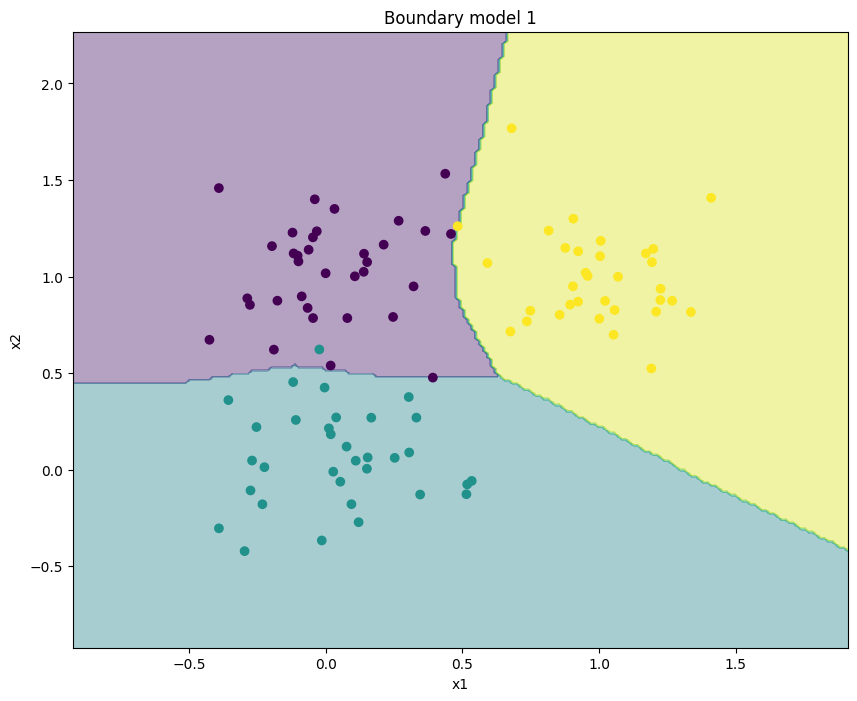

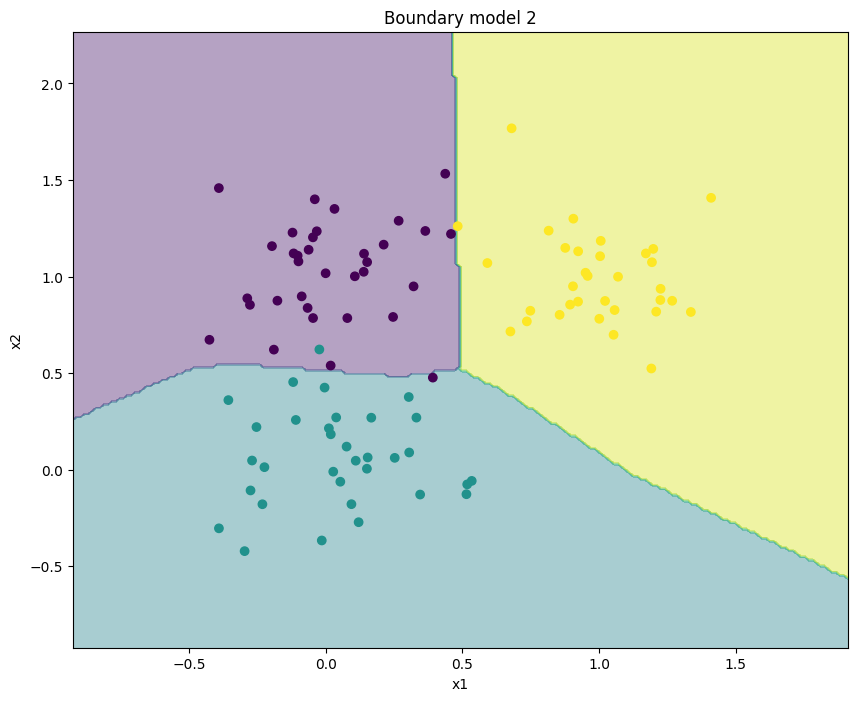

In [6]:
def plot_decision_regions(model, X, y, title="Decision Regions"):
    """
    Plot decision regions for a PyTorch model.
    
    Args:
        model: PyTorch model (must be in eval mode)
        X: Input features as tensor
        y: Labels as tensor
        title: Plot title
    """
    # Convert tensors to numpy for plotting
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    
    # Create a mesh grid
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    
    # Get predictions for each point in the mesh
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)
    
    # Plot decision regions
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    
    # Plot data points
    scatter = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, 
                         cmap='viridis')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

plot_decision_regions(model1, X_test, y_test, "Boundary model 1")
plot_decision_regions(model2, X_test, y_test, "Boundary model 2")

## Security Evaluation
<i>Given a distribution of points and two neural network architectures trained on these data, compute and plot their security evaluation against an L2 attack.</i>
<br><br>
The computation of security evaluations involve repeating attacks with increasing strength, hence it shuld approximate all the possible scenarios that can be envisioned once the models are deployed.

In [7]:
class Sample2DTracker(Tracker):
    def __init__(self) -> None:
        """Create adversarial 2D sample tracker."""
        super().__init__("Sample", MULTI_SCALAR)
        self.tracked = []

    def track(
        self,
        iteration: int,
        loss: torch.Tensor,
        scores: torch.Tensor,
        x_adv: torch.Tensor,
        delta: torch.Tensor,
        grad: torch.Tensor,
    ) -> None:
        self.tracked.append(x_adv)

perturbation_model = LpPerturbationModels.L2
single_sample_loader = DataLoader(TensorDataset(X_test[0:1,:], y_test[0:1]), batch_size=1, shuffle=False)

----------- SECURITY EVALUATION MODEL 1 -----------
For epsilon = 0.1 -> accuracy after attack:90.00
For epsilon = 0.3 -> accuracy after attack:70.00
For epsilon = 0.5 -> accuracy after attack:37.00
For epsilon = 0.7 -> accuracy after attack:12.00
For epsilon = 0.9 -> accuracy after attack:3.00
----------- SECURITY EVALUATION MODEL 2 -----------
For epsilon = 0.1 -> accuracy after attack:91.00
For epsilon = 0.3 -> accuracy after attack:72.00
For epsilon = 0.5 -> accuracy after attack:48.00
For epsilon = 0.7 -> accuracy after attack:31.00
For epsilon = 0.9 -> accuracy after attack:25.00


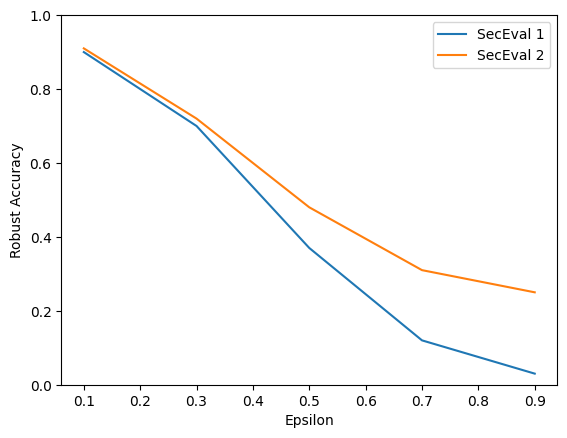

In [8]:
epsilons = [0.1, 0.3, 0.5, 0.7, 0.9]
alpha = 1e-2
num_iter = 100
lb = -2
ub = 2

def security_evaluation(model, dataloader, epsilons, iterations=num_iter, stepsize=alpha):
    sec_eval_data = []

    for e in epsilons:
        attack = PGD(
            perturbation_model=LpPerturbationModels.L2,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            epsilon=e,
            lb=lb,
            ub=ub,
            backend = Backends.NATIVE)
    
        adv_dataloader = attack(model, dataloader)
        print(f"For epsilon = {e} -> accuracy after attack:{Accuracy()(model, adv_dataloader) * 100:.2f}")

        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
        
    return sec_eval_data

print("----------- SECURITY EVALUATION MODEL 1 -----------")
sec_eval_model1 = security_evaluation(secmlt_model, ts_dataloader, epsilons=epsilons)

print("----------- SECURITY EVALUATION MODEL 2 -----------")
sec_eval_model2 = security_evaluation(secmlt_model2, ts_dataloader, epsilons=epsilons)

plt.plot(epsilons, sec_eval_model1, label='SecEval 1')
plt.plot(epsilons, sec_eval_model2, label='SecEval 2')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

## Results

<i>Discuss their results in terms of which could be more robust in this setting and why.</i>
<br><br>
By looking at the plot, it's clear that the most robust is the second model: as $\epsilon$ increases, model 2 degrades more gradually and it's still very much above the 0 at the higher $\epsilon$ value.<br>
This is because this model is much smaller, so it learns smoother and simpler decision regions, which are harder to perturb.